In [1]:
import sys
import os

# 获取项目根目录（即 `debug/` 目录的上一级）
project_root = os.path.abspath("..")  # 假设 `debug/` 目录是你的工作目录

# 添加 `project_root` 到 sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.param_periodic_koopman import ParamOrthogonalKoopmanWithInputs

In [2]:
import numpy as np
import torch

In [3]:
from src.data import get_evaluation_dataset
from src.args import parse_arguments, read_config_file

config_dir = "/home/shiqi/code/Project2-sensor-case/field-circuit-param-periodic-koopman/configs/Orthogonal/experiment_1.yaml"
config = read_config_file(config_dir)


In [4]:
data_dir = config["data_dir"]
step_size = config["step_size"]
pca_dim = config["pca_dim"]
state_dim = pca_dim
inputs_dim = 2
params_dim = 2
model = ParamOrthogonalKoopmanWithInputs(state_dim, config["dictionary_dim"], inputs_dim, params_dim, config["dictionary_layers"], config["Q_layers"], config["T_layers"], config["B_layers"])

In [5]:
device = torch.device('cpu')
# model_dict = torch.load(os.path.join(config["save_dir"], "model_state_dict.pth"))
# model.load_state_dict(model_dict)
model.to(device)
model.B_matrix.resnet.initialize_weights_to_zero()


In [6]:
from src.eval_param_periodic_orthogonal import evaluate_model, get_evaluation_dataset
data_list_train, params_list_train, inputs_list_train, data_list_test, params_list_test, inputs_list_test, dataset = get_evaluation_dataset(config['data_dir'], config['save_dir'], config['validation_split'])
data_list_train, data_pred_list_train = evaluate_model(model, data_list_train, params_list_train, inputs_list_train, dataset, config['sample_step'])

In [7]:
data = torch.tensor(data_list_train[0], dtype=torch.float64)
params = torch.tensor(params_list_train[0], dtype=torch.float64)
inputs = torch.tensor(inputs_list_train[0], dtype=torch.float64)
model.eval()
print(model.Q_matrix.skew_symmetric_matrix(params[:1, :]))

tensor([[[  0.0000,  -4.0778, -24.9525,  ...,   3.5526,   0.0679,   2.7589],
         [  4.0778,   0.0000,  -6.5842,  ...,  35.6419,  -6.8759,   1.0072],
         [ 24.9525,   6.5842,   0.0000,  ..., -12.8194,  -7.3571, -33.7682],
         ...,
         [ -3.5526, -35.6419,  12.8194,  ...,   0.0000,  -8.4027, -19.8236],
         [ -0.0679,   6.8759,   7.3571,  ...,   8.4027,   0.0000, -21.4380],
         [ -2.7589,  -1.0072,  33.7682,  ...,  19.8236,  21.4380,   0.0000]]],
       grad_fn=<SubBackward0>)


In [8]:
model.Q_matrix(params[:1, :])

tensor([[[ 0.4202, -0.2001, -0.0802,  ..., -0.0867, -0.1052,  0.0768],
         [-0.1516,  0.4229,  0.0811,  ...,  0.2063,  0.0612, -0.0255],
         [-0.1938, -0.0106,  0.4136,  ..., -0.0762,  0.0960,  0.1273],
         ...,
         [-0.1251, -0.2275,  0.0593,  ...,  0.1338,  0.0932, -0.3083],
         [ 0.0568,  0.1305, -0.0620,  ...,  0.1375,  0.1040,  0.0204],
         [-0.1011,  0.0704,  0.0159,  ...,  0.1763,  0.0604, -0.2657]]],
       grad_fn=<LinalgMatrixExpBackward0>)

In [9]:
model.T_matrix(params[:1, :])
eigenvalues, _ = torch.linalg.eig(model.T_matrix(params[:1, :])[0])
print(eigenvalues)
spectral_radius = max(abs(eigenvalues))
print(f"Spectral Radius: {spectral_radius}")

tensor([-0.8504+0.5262j, -0.8504-0.5262j, -0.0083+1.0000j, -0.0083-1.0000j,
        -0.0743+0.9972j, -0.0743-0.9972j, -0.8654+0.5010j, -0.8654-0.5010j,
         0.7732+0.6342j,  0.7732-0.6342j, -0.8091+0.5877j, -0.8091-0.5877j,
        -0.9569+0.2903j, -0.9569-0.2903j, -0.7894+0.6139j, -0.7894-0.6139j,
         0.3878+0.9217j,  0.3878-0.9217j,  0.7323+0.6809j,  0.7323-0.6809j,
         0.8860+0.4637j,  0.8860-0.4637j, -0.9954+0.0954j, -0.9954-0.0954j,
        -0.5593+0.8289j, -0.5593-0.8289j,  0.1461+0.9893j,  0.1461-0.9893j,
         0.9164+0.4003j,  0.9164-0.4003j,  0.8403+0.5422j,  0.8403-0.5422j,
         0.0266+0.9996j,  0.0266-0.9996j, -0.8319+0.5549j, -0.8319-0.5549j,
         0.9888+0.1493j,  0.9888-0.1493j,  0.9686+0.2487j,  0.9686-0.2487j,
        -0.9870+0.1605j, -0.9870-0.1605j,  0.5858+0.8105j,  0.5858-0.8105j,
         0.6479+0.7617j,  0.6479-0.7617j,  0.5164+0.8563j,  0.5164-0.8563j,
         0.8194+0.5732j,  0.8194-0.5732j], grad_fn=<LinalgEigBackward0>)
Spectral Radius

In [10]:
T_matrix = model.T_matrix(params[:1, :])[0]

# 打印 T 矩阵
print("T matrix:")
print(T_matrix)
# 对 T 矩阵进行分解
U, S, V = torch.svd(T_matrix)

# 验证分解结果
T_reconstructed = U @ torch.diag(S) @ V.T
print("Reconstructed T matrix:")
print(T_reconstructed)

T matrix:
tensor([[-0.8504,  0.5262,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5262, -0.8504,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0083,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5164,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.8194, -0.5732],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.5732,  0.8194]],
       grad_fn=<SelectBackward0>)
Reconstructed T matrix:
tensor([[-0.8504,  0.5262,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5262, -0.8504,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0083,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5164,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.8194, -0.5732],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.5732,  0.8194]],
       grad_fn=<MmBackward0>)


In [11]:
print("Singular values:")
print(S)

Singular values:
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<LinalgSvdBackward0>)


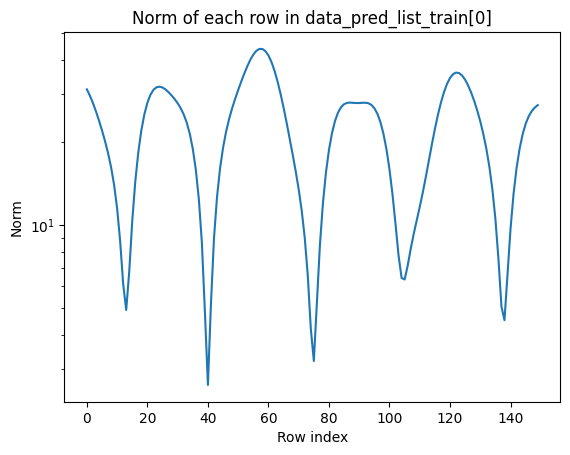

In [12]:
# data_pred_list_train[0][:, 0]
import matplotlib.pyplot as plt

norms = np.linalg.norm(data_pred_list_train[0], axis=1)
plt.plot(norms)
plt.xlabel('Row index')
plt.ylabel('Norm')
plt.yscale('log')
plt.title('Norm of each row in data_pred_list_train[0]')
plt.show()

In [13]:
print(model.Q_matrix(params[:1, :])[0].shape)

torch.Size([50, 50])


In [14]:
mse = torch.nn.MSELoss()
koopman_dim = 1 + state_dim + config["dictionary_dim"]
identity_matrix = torch.eye(koopman_dim, dtype=torch.float64)
result = mse(model.Q_matrix(params[:1, :])[0] @ model.Q_matrix(params[:1, :])[0].T, identity_matrix)
print(result)

tensor(3.3292e-28, grad_fn=<MseLossBackward0>)


In [15]:
print(model.B_matrix(params[:1, :])[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<SelectBackward0>)
